## Implementing PyStan to run logistic regressions using the IBL dataset

In [1]:
import pystan
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import arviz
from os.path import isfile, join

In [2]:
# change to desired directory (preferrably the main IBL folder with all the different lab directories)

os.chdir('psy504_data/ibl_data/')

Here are some functions to extract and help organize the data.

In [31]:
def sort_titles(string):
    return string.split('.')[1]

def extract_data(dataPath):

    data  = [file for file in os.listdir(dataPath) if isfile(join(dataPath, file))]

    df = pd.DataFrame()

    for i, file in enumerate(data):
        dfile = np.load(dataPath+file)
        if dfile.ndim != 1:
            print("The column '"+sort_titles(file)+"' at index = "+str(i)+" is multidimensional.")
            add_idx = i
        df_new = pd.DataFrame(data=dfile)
        df = pd.concat([df, df_new], axis=1)

    # we subtract the first col with the second col to obtain intervals (s)
        
    col_names = [sort_titles(title) for title in data]
    
    # since some of files we appended != 1 ndims, we have to insert a new title to our title list
    col_names.insert(add_idx+1, 'end_trial')
    col_names[add_idx] = 'response_time'
    df.columns = col_names
    
    # we subtract the first col with the second col to obtain interval (s)
    df.insert(add_idx+2,'interval', df.iloc[:,add_idx+1]-df.iloc[:,add_idx])
    
    if len(np.unique(df['choice'])) != 2:
        print('Dataset is not in binary outcome format.')
    
    for col in df.columns:
        if pd.isna(df[col]).any() == True:
            print("The column '"+col+"' has NANs.")

    return df

def solve_NANs(df, cols, title):
    '''
    processes pair of nan columns by replacing nans in one with the real values of the other and inserts this 
    as a new column
    
    inputs:
        df = dataframe with the nan columns
        cols = str of columns with nans
        title = str for name of new column
        
    '''
    nan_col = np.copy(df[cols[0]])
    nan_idx = np.where(pd.isna(nan_col) == True)[0]
    nan_col[nan_idx] = df[cols[1]][nan_idx]
    df.insert(df.shape[1], title, nan_col)
    
    return df

def drop_cols(df, cols):
    dropped_cols = []
    for col in df.columns:
        if col not in cols:
            dropped_cols.append(col)
    df = df.drop(dropped_cols, axis=1)
    
    return df

dataPath = 'wittenlab/Subjects/ibl_witten_04/2019-08-06/002/alf/'
df = extract_data(dataPath)
df = solve_NANs(df, ['contrastLeft', 'contrastRight'], 'contrast')
df = drop_cols(df, ['contrast', 'feedbackType', 'interval', 'rewardVolume', 'choice'])
df['choice'] = np.where(df['choice'] == -1, 0, 1)
        
df.head()

The column 'intervals' at index = 7 is multidimensional.
The column 'contrastLeft' has NANs.
The column 'contrastRight' has NANs.


,choice,rewardVolume,interval,feedbackType,contrast
0,0,1.5,3.806602,1,1.0000
1,1,1.5,2.708302,1,0.0000
2,1,1.5,2.335302,1,0.0000
3,0,1.5,2.810102,1,0.2500
4,1,1.5,2.363302,1,0.0625


Now: pystan.

In [41]:
IBL_code = """

data {
    int <lower = 0> N; // number of data items
    int <lower = 0> P; // number of predictors
    matrix[N, P] X;    // predictor matrix
    int <lower = 0, upper = 1> y[N]; //outcome vector
}
parameters {
    real alpha; // intercept
    vector[P] beta; // regression parameters 
    real <lower = 0> sigma; // error scale
}
transformed parameters {
    real<lower=0> odds[N];
    real<lower=0, upper=1> prob[N];
    for (i in 1:N) {
         odds[i] = exp(X[i, :] * beta + alpha);
         prob[i] = odds[i] / (odds[i] + 1);
     }
}
model {
  y ~ bernoulli(prob);
}
"""

IBL_dat = {
    'N': 300,
    'P': 4,
    'X': df.iloc[::3,1:],
    'y': df['choice'][::3]
}
ctrl = {
    'adapt_delta': 0.9999999,
    'max_treedepth': 12
}

fit = pystan.stan(model_code=IBL_code, data=IBL_dat, iter=6000, warmup=3000, chains=6, thin=10, seed=42069, 
                  control=ctrl)

print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_25f2a27269c895671cc8603cbbd8aefe NOW.


In [42]:
print(fit)

Inference for Stan model: anon_model_25f2a27269c895671cc8603cbbd8aefe.
6 chains, each with iter=6000; warmup=3000; thin=10; 
post-warmup draws per chain=300, total post-warmup draws=1800.

            mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
alpha     -222.1  132.63 367.47   -1060  -469.4  -173.5   12.21  382.54      8   2.12
beta[1]    295.9  176.84 489.93  -509.9  -16.01   231.2  625.74  1412.8      8   2.12
beta[2]     0.03  3.5e-3   0.05   -0.07 -5.5e-3    0.03    0.06    0.14    229   1.02
beta[3]   -221.5  132.63 367.44   -1059  -468.9  -173.0    12.3  383.01      8   2.12
beta[4]    -0.72    0.03   0.33   -1.33   -0.95   -0.72   -0.48   -0.12    147   1.01
sigma        inf     nan    inf 7.1e306 4.8e307 8.8e307 1.3e308 1.7e308    nan    nan
odds[1]      0.7    0.01   0.19    0.41    0.57    0.68    0.81    1.13    237   1.01
odds[2]     1.15  4.4e-3   0.15    0.88    1.04    1.13    1.24    1.48   1214    1.0
odds[3]     0.69    0.01   0.17     0

<Figure size 432x288 with 0 Axes>

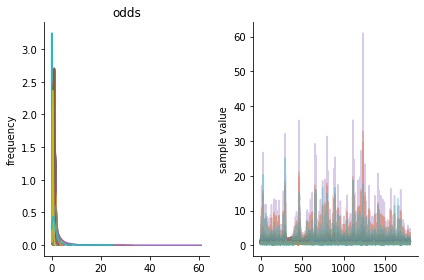

<Figure size 432x288 with 0 Axes>

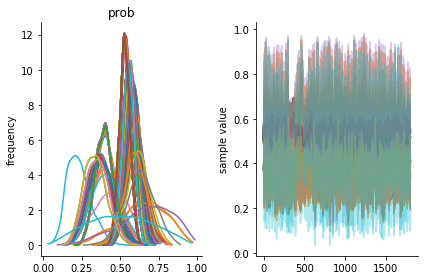

In [43]:
plt.figure()
fit.plot('odds')
plt.tight_layout()
sns.despine()

plt.figure()
fit.plot('prob')
plt.tight_layout()
sns.despine()

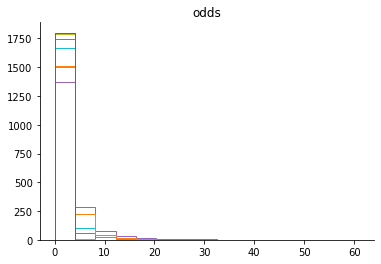

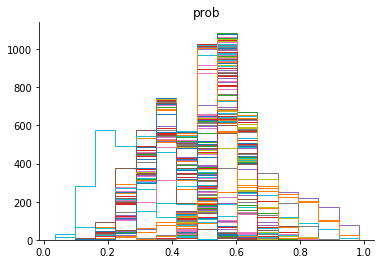

In [44]:
IBL_dict = fit.extract()

plt.figure()
plt.hist(IBL_dict['odds'][:], 15, histtype='step')
plt.title('odds')
sns.despine()

plt.figure()
plt.hist(IBL_dict['prob'][:], 15, histtype='step')
plt.title('prob')
sns.despine()